In [6]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Load the dataset
data = pd.read_csv("emi_train_sample.csv")

# Drop DeviceID (categorical) and separate features/targets
X = data.drop(columns=["DeviceID",
    'voltage_rise_time_pulse1', 'voltage_rise_time_pulse2',
    'voltage_fall_time_pulse1', 'voltage_fall_time_pulse2',
    'current_rise_time_pulse1', 'current_rise_time_pulse2',
    'current_fall_time_pulse1', 'current_fall_time_pulse2',
    'overshoot_pulse_1', 'overshoot_pulse_2',
    'undershoot_pulse_1', 'undershoot_pulse_2',
    'ringing_frequency_MHz'])

y = data[['voltage_rise_time_pulse1', 'voltage_rise_time_pulse2',
          'voltage_fall_time_pulse1', 'voltage_fall_time_pulse2',
          'current_rise_time_pulse1', 'current_rise_time_pulse2',
          'current_fall_time_pulse1', 'current_fall_time_pulse2',
          'overshoot_pulse_1', 'overshoot_pulse_2',
          'undershoot_pulse_1', 'undershoot_pulse_2',
          'ringing_frequency_MHz']]

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


Splitting the data

c:\Users\pc\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\lib\_function_base_impl.py:2922: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\pc\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\lib\_function_base_impl.py:2923: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
c:\Users\pc\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.367051568226948e-19, tolerance: 5.35748272775e-19
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\pc\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.538414606827774e-19, tolerance: 5.35748272775e-19
  model = cd_f

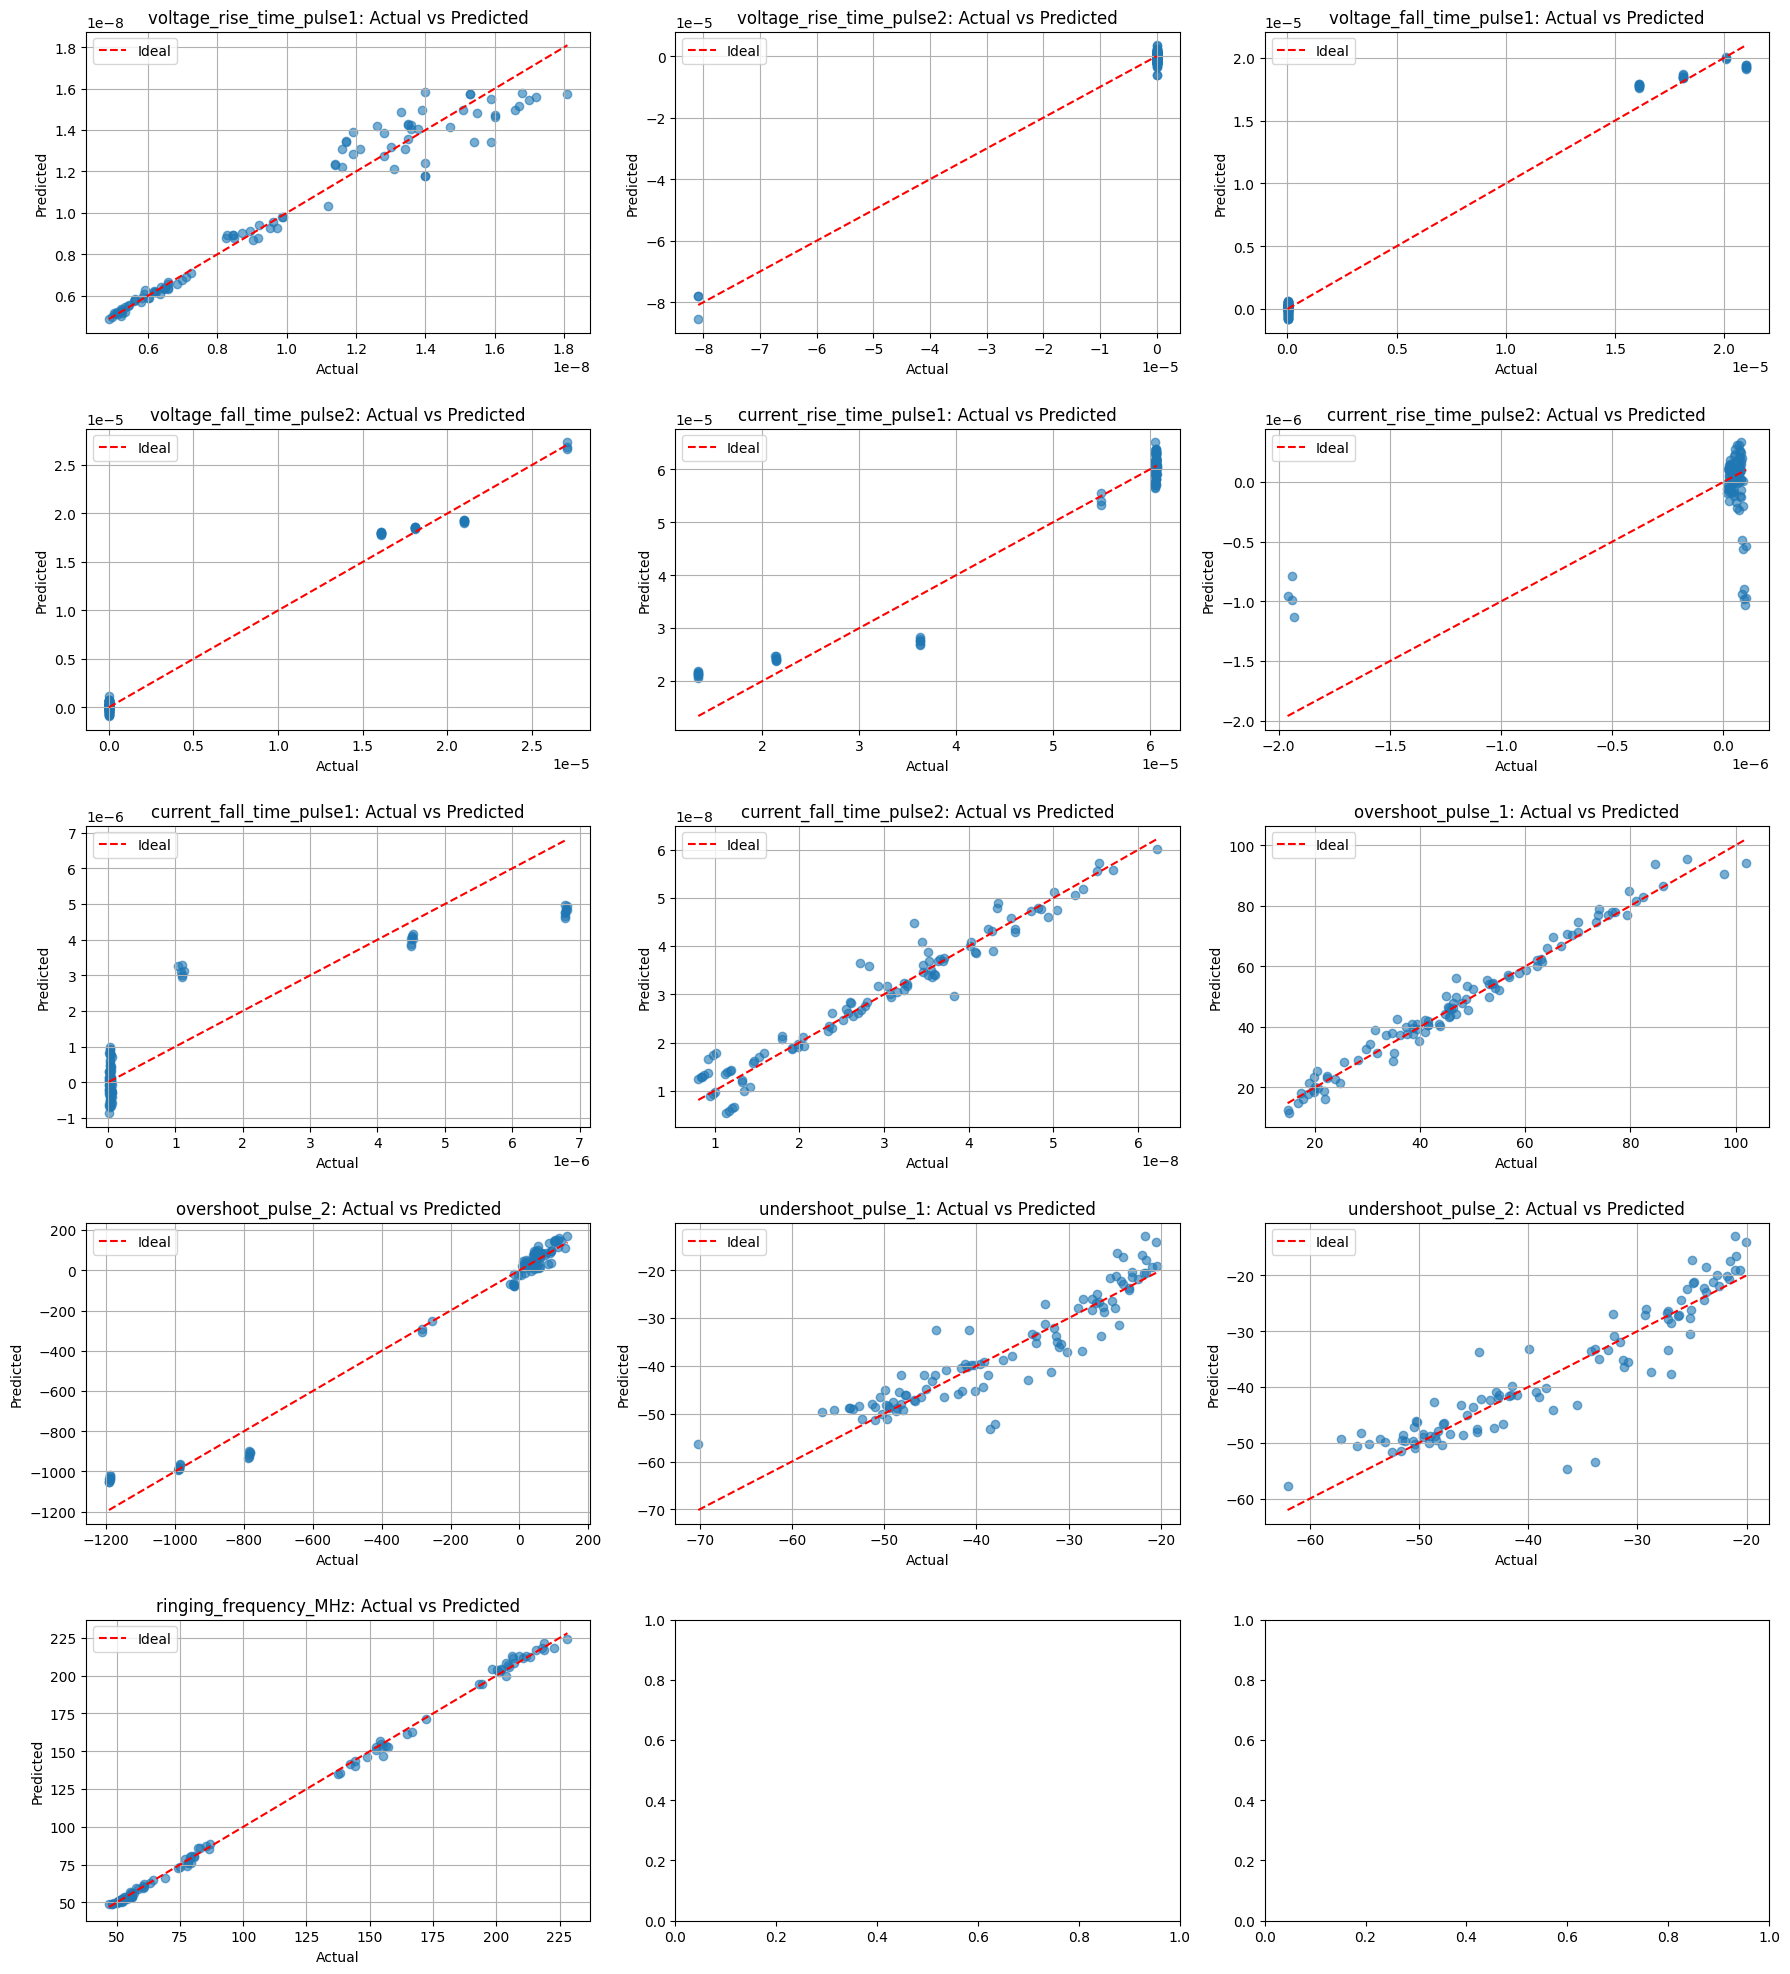

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, LassoCV
from sklearn.feature_selection import RFE
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.decomposition import PCA


# Load data
data = pd.read_csv("emi_train_sample.csv")

# Drop DeviceID and separate features/targets
X = data.drop(columns=["DeviceID",
    'voltage_rise_time_pulse1', 'voltage_rise_time_pulse2',
    'voltage_fall_time_pulse1', 'voltage_fall_time_pulse2',
    'current_rise_time_pulse1', 'current_rise_time_pulse2',
    'current_fall_time_pulse1', 'current_fall_time_pulse2',
    'overshoot_pulse_1', 'overshoot_pulse_2',
    'undershoot_pulse_1', 'undershoot_pulse_2',
    'ringing_frequency_MHz'])

y = data[['voltage_rise_time_pulse1', 'voltage_rise_time_pulse2',
          'voltage_fall_time_pulse1', 'voltage_fall_time_pulse2',
          'current_rise_time_pulse1', 'current_rise_time_pulse2',
          'current_fall_time_pulse1', 'current_fall_time_pulse2',
          'overshoot_pulse_1', 'overshoot_pulse_2',
          'undershoot_pulse_1', 'undershoot_pulse_2',
          'ringing_frequency_MHz']]

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Train Linear Regression
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
y_pred = lr_model.predict(X_test)

# Evaluation metrics (compatible with older sklearn)
r2 = r2_score(y_test, y_pred, multioutput='uniform_average')
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)


# Pearson correlation (with 1st target)
corr_matrix = pd.DataFrame(X_scaled, columns=X.columns).corrwith(y['voltage_rise_time_pulse1']).abs()
top_corr_features = corr_matrix.sort_values(ascending=False).head(20)

# RFE feature selection
rfe = RFE(estimator=LinearRegression(), n_features_to_select=10)
rfe.fit(X_scaled, y['voltage_rise_time_pulse1'])
rfe_selected = X.columns[rfe.support_]

# Lasso feature selection
lasso = LassoCV(cv=5).fit(X_scaled, y['voltage_rise_time_pulse1'])
lasso_selected = X.columns[np.abs(lasso.coef_) > 1e-4]

# Actual vs Predicted plots for all 13 outputs
fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(18, 20))
axes = axes.flatten()

for i, col in enumerate(y.columns):
    axes[i].scatter(y_test[col], y_pred[:, i], alpha=0.6)
    axes[i].plot([y_test[col].min(), y_test[col].max()],
                 [y_test[col].min(), y_test[col].max()],
                 'r--', label="Ideal")
    axes[i].set_title(f"{col}: Actual vs Predicted")
    axes[i].set_xlabel("Actual")
    axes[i].set_ylabel("Predicted")
    axes[i].grid(True)
    axes[i].legend()

plt.tight_layout()
plt.show()


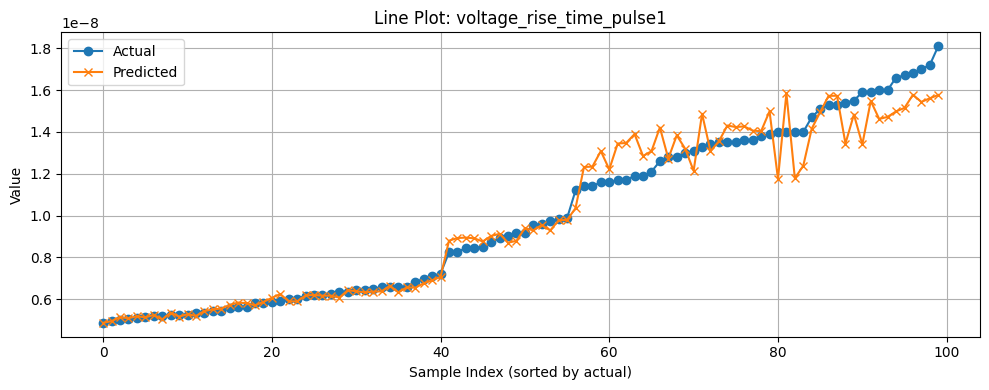

In [11]:
import matplotlib.pyplot as plt

target_col = 'voltage_rise_time_pulse1'  # You can loop over other targets too
pred_col = target_col + "_pred"

# Sort by actual values for clarity
sorted_idx = y_test[target_col].reset_index(drop=True).sort_values().index
actual_sorted = y_test[target_col].reset_index(drop=True).iloc[sorted_idx]
pred_sorted = pd.Series(y_pred[:, y.columns.get_loc(target_col)]).iloc[sorted_idx]

plt.figure(figsize=(10, 4))
plt.plot(actual_sorted.values, label="Actual", marker='o')
plt.plot(pred_sorted.values, label="Predicted", marker='x')
plt.title(f"Line Plot: {target_col}")
plt.xlabel("Sample Index (sorted by actual)")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


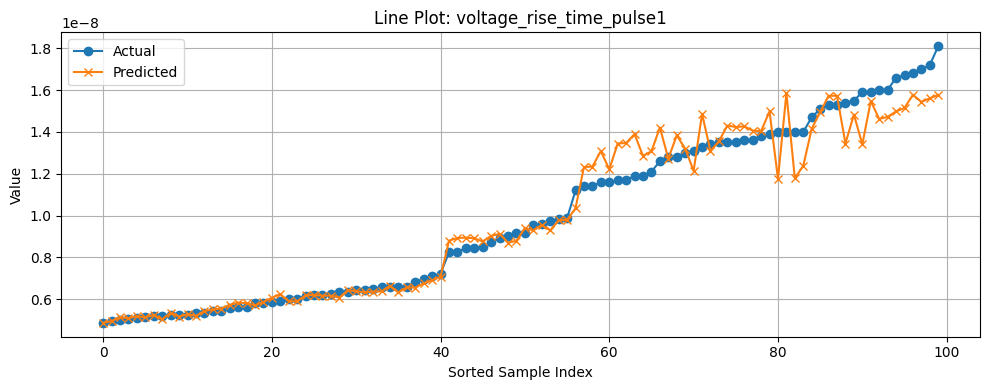

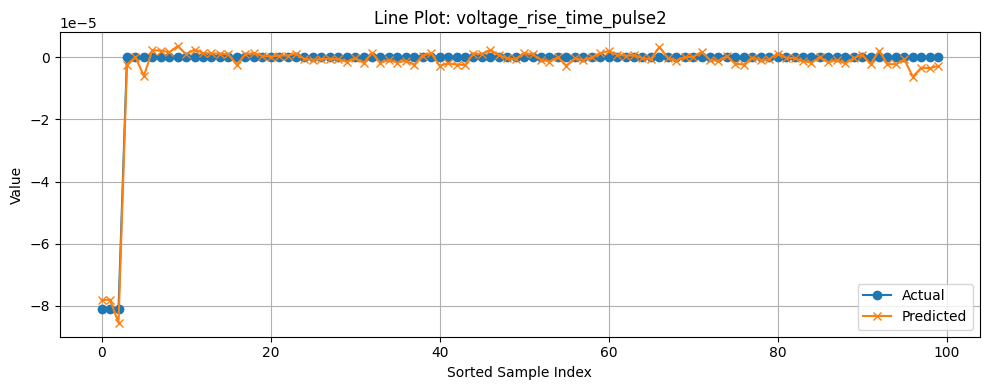

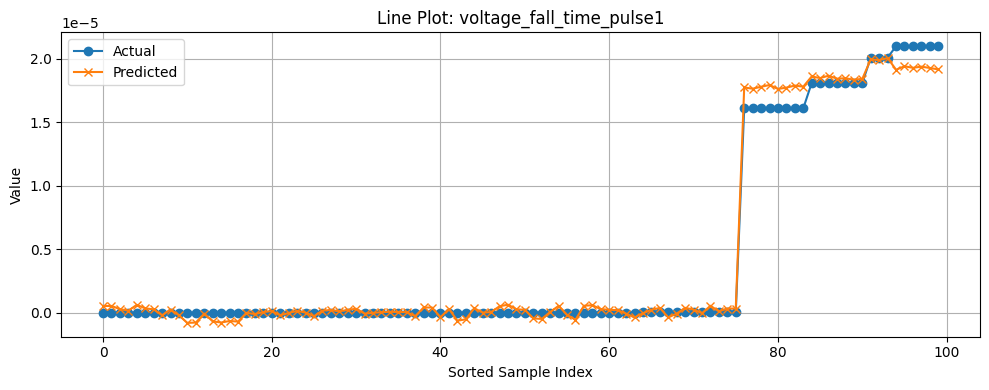

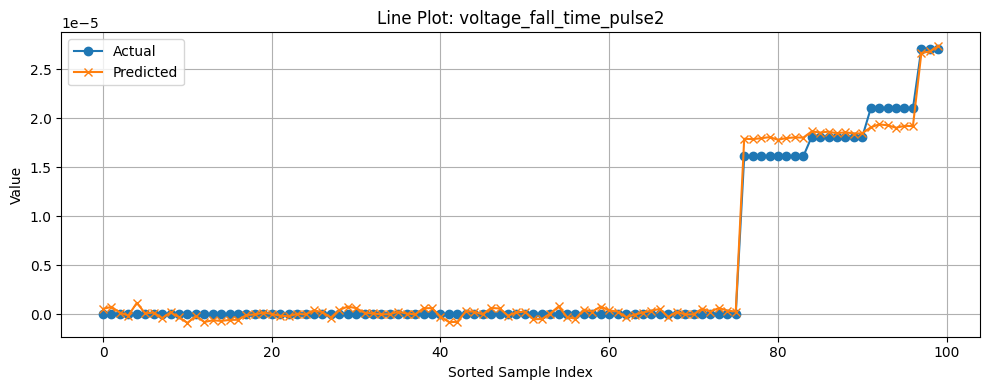

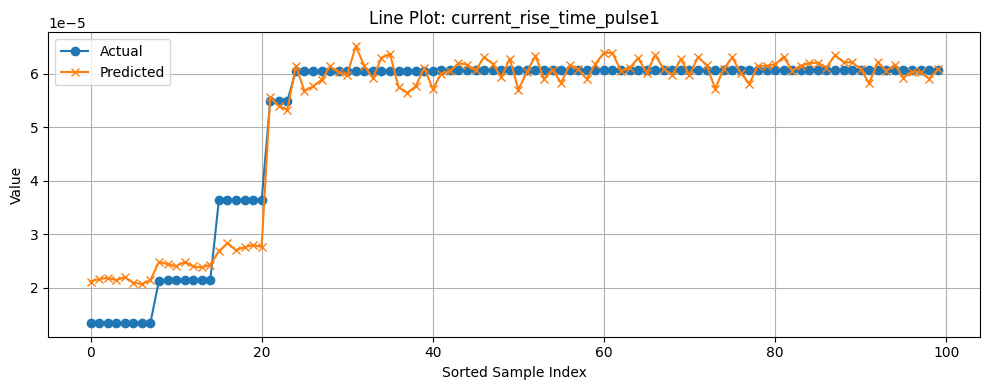

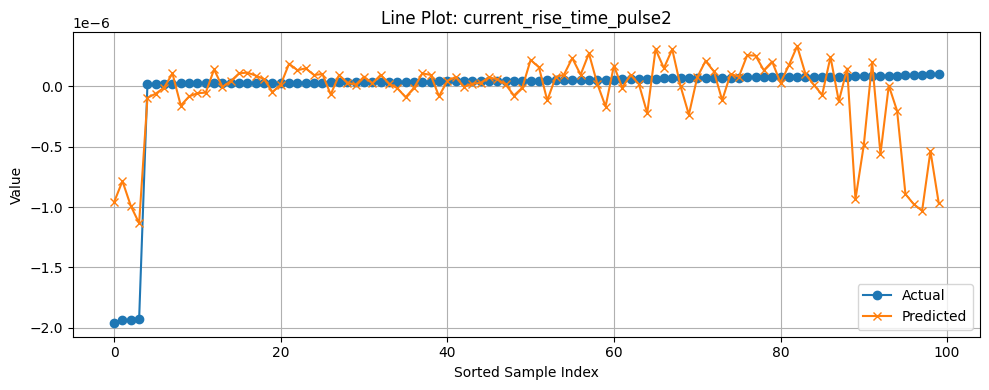

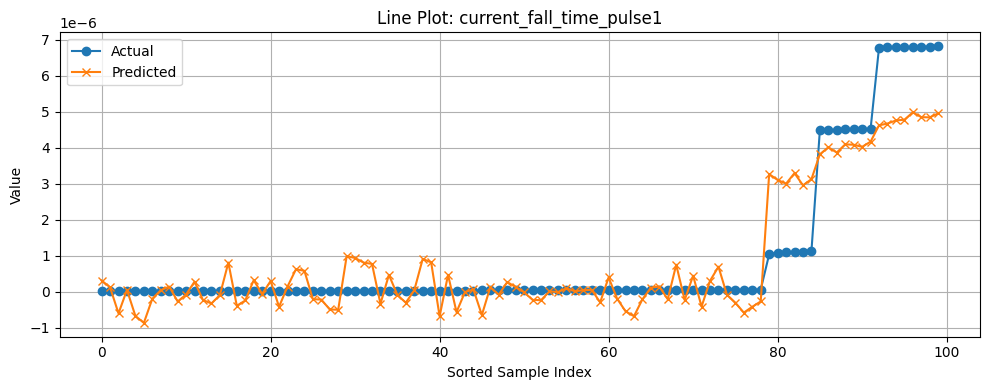

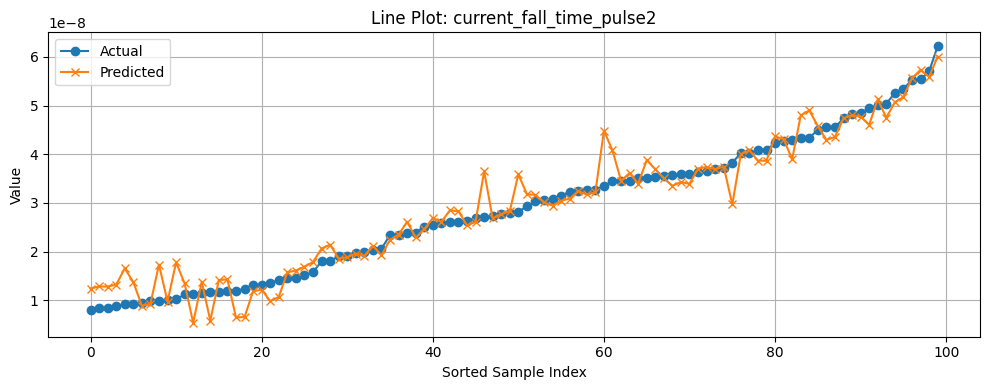

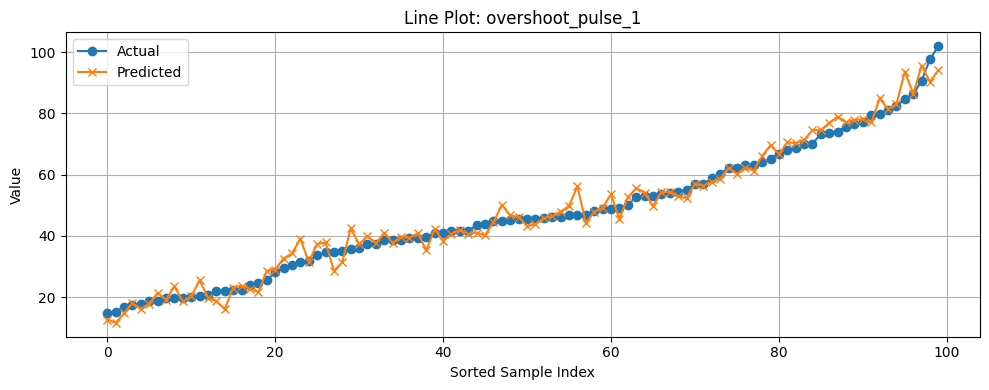

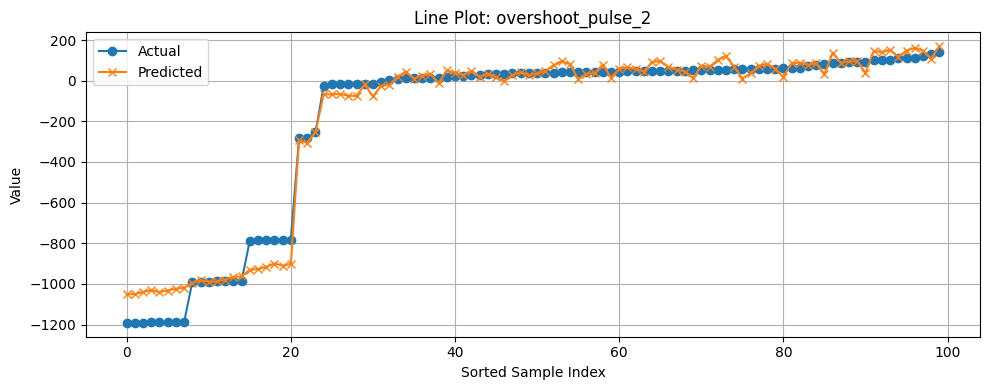

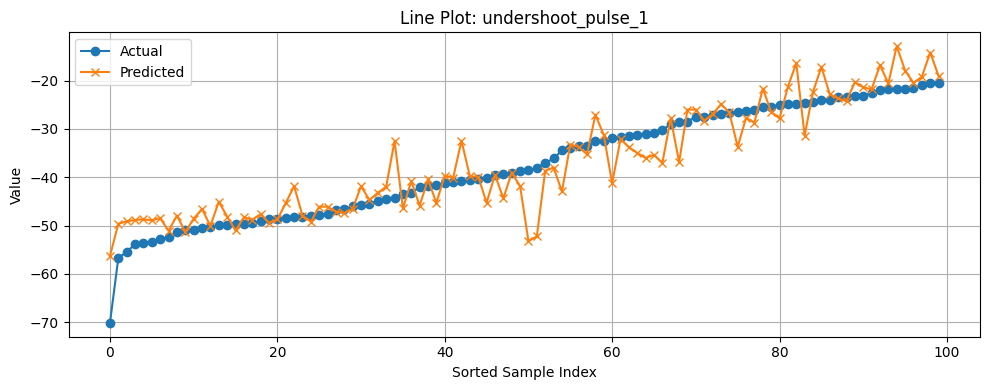

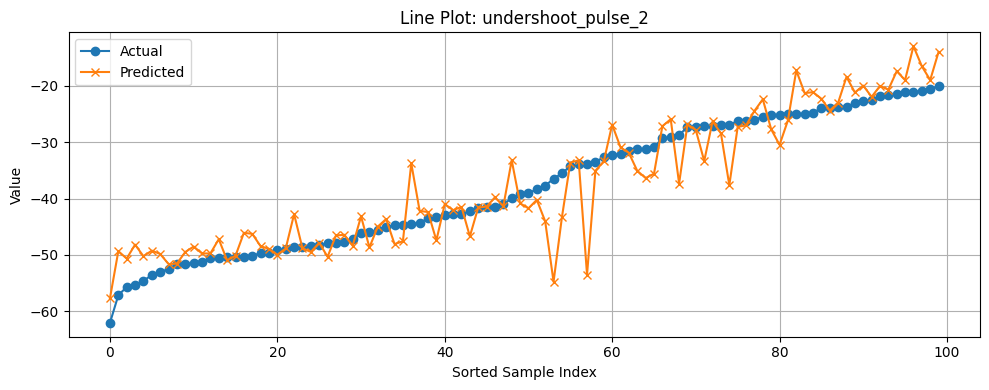

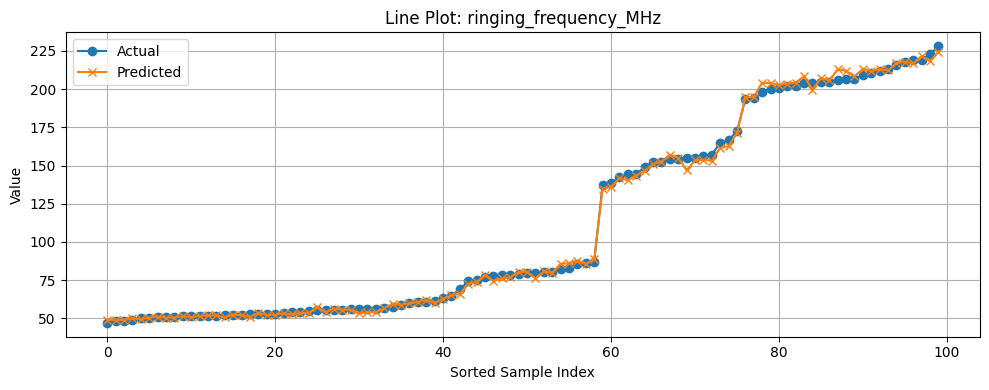

In [14]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Loop through all target columns
for target_col in y.columns:
    pred_col = target_col + "_pred"
    actual = y_test[target_col].reset_index(drop=True)
    predicted = pd.Series(y_pred[:, y.columns.get_loc(target_col)])
    
    # Sort by actual for line clarity
    sorted_idx = actual.sort_values().index
    actual_sorted = actual.iloc[sorted_idx]
    pred_sorted = predicted.iloc[sorted_idx]
    
    # Line Plot
    plt.figure(figsize=(10, 4))
    plt.plot(actual_sorted.values, label="Actual", marker='o')
    plt.plot(pred_sorted.values, label="Predicted", marker='x')
    plt.title(f"Line Plot: {target_col}")
    plt.xlabel("Sorted Sample Index")
    plt.ylabel("Value")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [15]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import pandas as pd
import numpy as np

# Evaluate performance for each target column
target_performance = []

for i, col in enumerate(y.columns):
    actual = y_test[col].reset_index(drop=True)
    predicted = y_pred[:, i]
    
    r2 = r2_score(actual, predicted)
    rmse = np.sqrt(mean_squared_error(actual, predicted))  # compatible with older sklearn
    mae = mean_absolute_error(actual, predicted)
    
    target_performance.append({
        "Target": col,
        "R2 Score": round(r2, 4),
        "RMSE": rmse,
        "MAE": mae
    })

# Create a DataFrame with results
performance_df = pd.DataFrame(target_performance)
print(performance_df)


                      Target  R2 Score          RMSE           MAE
0   voltage_rise_time_pulse1    0.9510  8.803032e-10  5.889906e-10
1   voltage_rise_time_pulse2    0.9823  1.838091e-06  1.423272e-06
2   voltage_fall_time_pulse1    0.9917  7.194996e-07  4.936100e-07
3   voltage_fall_time_pulse2    0.9911  7.945995e-07  5.597164e-07
4   current_rise_time_pulse1    0.9486  3.623682e-06  2.568115e-06
5   current_rise_time_pulse2    0.2296  3.438431e-07  1.921387e-07
6   current_fall_time_pulse1    0.8289  8.562617e-07  5.898047e-07
7   current_fall_time_pulse2    0.9447  3.269666e-09  2.312848e-09
8          overshoot_pulse_1    0.9766  3.143805e+00  2.366707e+00
9          overshoot_pulse_2    0.9806  6.066069e+01  4.051035e+01
10        undershoot_pulse_1    0.8321  4.584015e+00  3.286218e+00
11        undershoot_pulse_2    0.8379  4.549832e+00  3.127722e+00
12     ringing_frequency_MHz    0.9987  2.349738e+00  1.761042e+00


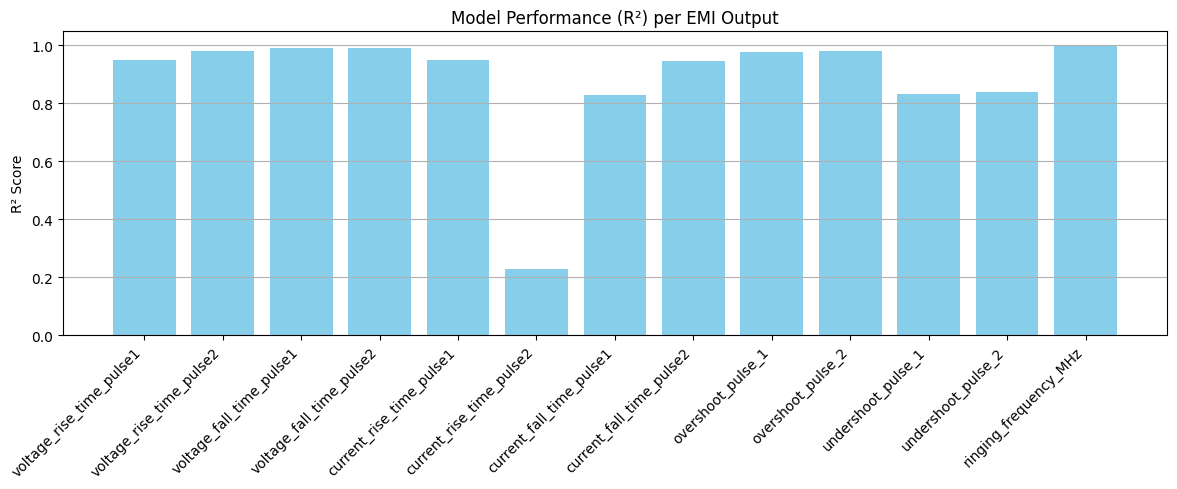

In [16]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.bar(performance_df["Target"], performance_df["R2 Score"], color='skyblue')
plt.xticks(rotation=45, ha='right')
plt.ylabel("R² Score")
plt.title("Model Performance (R²) per EMI Output")
plt.tight_layout()
plt.grid(True, axis='y')
plt.show()
